# Optimization under constraints

We previously considered multivariate optimization. However, in many settings, we are interested in optimizing functions subject to constraints. For example, in disordered systems, we are often interested in finding the minima of a landscape, but the minima are subject to the constraint that the system is a unit cell. In mechanics, we are often interested in finding the minima of a Hamiltonian describing a system like a pendulum, but the minima are subject to geometric constraints among the optimization variables.

Preamble: Run the cells below to import the necessary Python packages

<!-- *This notebook created by William Gilpin. Consult the [course website](https://www.wgilpin.com/cphy) for all content and [GitHub repository](https://github.com/williamgilpin/cphy) for raw files and runnable online code.* -->

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/williamgilpin/cphy/blob/main/talks/optimization_multivariate.ipynb)

In [1]:
import numpy as np
from IPython.display import Image, display

import matplotlib.pyplot as plt
%matplotlib inline

## Set nicer colors
plt.rcParams['image.cmap'] = 'PuBu'
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=[[1.0, .3882, .2784]])
plt.rcParams['lines.markersize'] = 10


### The Gaussian landscape


We will again consider a optimize a two-dimensional landscape consisting of a sum of Gaussian wells,
$$
\mathcal{L}_{\boldsymbol{\mu}, \boldsymbol{\sigma}}(\mathbf{x}) = \sum_{p=1}^P \mathcal{L}_p = -\sum_{p=1}^P A_p \exp\left(-\frac{(\mathbf{x} - \boldsymbol{\mu}_{p})^2}{2\sigma^2}\right)
$$
where $\mathbf{x} \in \mathbb{R}^D$ is the position in the landscape, $\boldsymbol{\mu}_p \in \mathbb{R}^D$ is the location of the $p^{th}$ well, and $\sigma \in \mathbb{R}^D$ is the width of the wells. The weights $\sum_p A_p = 1$, $A_p \geq 0$ are the relative depths of the wells. 

The gradient of the landscape is given by
$$
    \nabla \mathcal{L} = \sum_{p=1}^P A_p\frac{(\mathbf{x} - \boldsymbol{\mu}_{p})}{\sigma^2} \exp\left(-\frac{(\mathbf{x} - \boldsymbol{\mu}_{p})^2}{2\sigma^2}\right)
$$

In [3]:

class RandomLossLandscape:
    """
    Creates a random two-dimensional loss landscape with multiple circular gaussian wells

    Args:
        d (int): number of dimensions for the loss landscape
        n_wells (int): number of gaussian wells
        random_state (int): random seed
    
    """

    def __init__(self, d=2, n_wells=3, random_state=None):
        
        # Fix the random seed
        self.random_state = random_state
        np.random.seed(random_state)

        # Select random well locations, widths, and amplitudes
        self.locs = (2 * np.random.uniform(size=(n_wells, d)) - 1) * 3
        self.widths = np.random.rand(n_wells)[None, :]
        self.coeffs = np.random.random(n_wells)
        self.coeffs /= np.sum(self.coeffs) # normalize the amplitudes

    def _gaussian_well(self, X, width=1):
        """
        A single gaussian well centered at 0 with specified width

        Args:
            X (np.ndarray): points at which to compute the gaussian well. This should 
                be of shape (n_batch, n_dim)
            width (float): The width of the gaussian well

        Returns:
            np.ndarray: The value of the gaussian well at points X. The shape of the output
                is (n_batch,)
        """
        return -np.exp(-np.sum((X / width) ** 2, axis=1))

    def _grad_gaussian_well(self, X, width=1):
        return -2 * X / (width ** 2) * self._gaussian_well(X, width)[:, None, :]

    def grad(self, X):
        # Arg shape before summation is (n_batch, n_dim, n_wells)
        return np.sum(
            self.coeffs * self._grad_gaussian_well(X[..., None] - self.locs.T[None, :], self.widths), 
            axis=-1
        )
    
    def loss(self, X):
        """
        Compute the loss landscape at points X

        Args:
            X (np.ndarray): points at which to compute the loss landscape. This should 
                be of shape (n_batch, n_dim)
            width (float): The width of the gaussian wells

        Returns:
            np.ndarray: loss landscape at points X

        Notes:
            The loss landscape is computed as the sum of the individual gaussian wells
            The shape of the argument to np.sum is (n_batch, n_wells)
        """
        return np.sum(
            self._gaussian_well(X[..., None] - self.locs.T[None, :], self.widths) * self.coeffs,
            axis=1
        )

    def __call__(self, X):
        return self.loss(X)

We will plot the landscape and its gradient, which consists of a two-dimensional vector field.

(10000, 2)


(np.float64(-3.3), np.float64(3.3), np.float64(-3.3), np.float64(3.3))

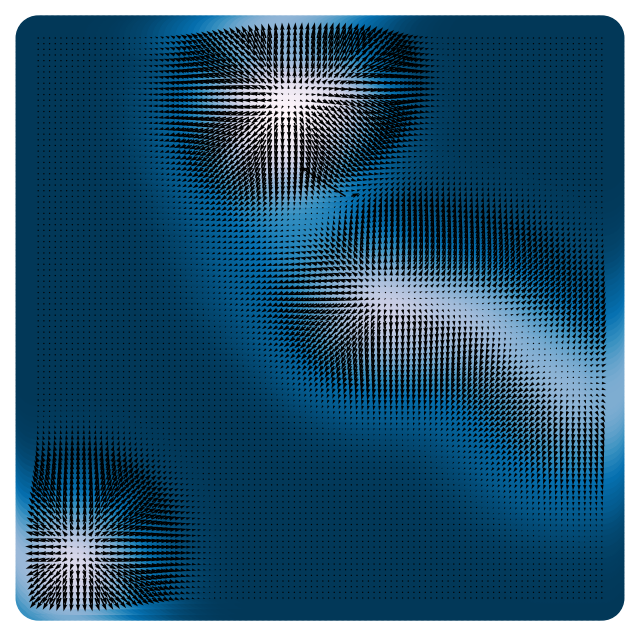

In [4]:
loss = RandomLossLandscape(random_state=0, n_wells=8)

plt.figure(figsize=(8, 8))

## First we plot the scalar field at high resolution
x = np.linspace(-3, 3, 100)
y = np.linspace(-3, 3, 100)
xx, yy = np.meshgrid(x, y)
X = np.array([xx.ravel(), yy.ravel()]).T
print(X.shape)
Z = loss(X) # same as loss.loss(X) because class is callable
plt.scatter(X[:, 0], X[:, 1], c=Z, s=1000)

# x = np.linspace(-3, 3, 15)
# y = np.linspace(-3, 3, 15)
# xx, yy = np.meshgrid(x, y)
# X = np.array([xx.ravel(), yy.ravel()]).T
# Z = loss.loss(X)
plt.quiver(X[:, 0], X[:, 1], loss.grad(X)[:, 0], loss.grad(X)[:, 1], scale=1e1, color='k')
plt.axis('off')

# Optimization under constraints

We usually optimize a loss function $\mathcal{L}(\mathbf{x})$ by varying $\mathbf{x}$ using heuristics such as gradient descent. In a constrained optimization problem, there exist constraints among the various components of $\mathbf{x}$ that must be preserved. 

For example, if $\mathbf{x}$ represents a wavefunction and $\mathcal{L}(\mathbf{x})$ represents its energy, there could exist a normalization constraint, $\mathbf{x} \cdot \mathbf{x} = 1$. If $\mathcal{L}(\mathbf{x})$ represents the current through a network of $N$ resistors with values $x_i$, there exists a positivity constraint $x_i \geq 0$ for all $i$.

We will consider the case of equality constraints, which generically take the form of a scalar equation
$$
    \mathcal{C}(\mathbf{x}) = 0
$$


# Projected gradient descent

Our standard gradient descent update rule is given by
$$
    \mathbf{x} \leftarrow \mathbf{x} - \eta \nabla \mathcal{L}(\mathbf{x})
$$
In this formulation, the individual components of our vector $\mathbf{x}$ are been updated independently of each other. The update even be performed in parallel across components of $\mathbf{x}$. However, what if we want to constrain the components of $\mathbf{x}$ to lie on a surface? For example, we might want to constrain the components of $\mathbf{x}$ to lie on a unit sphere,
$$
    \sum_i x_i^2 = 1
$$

If we denote the restricted set as $\mathcal{S} = \{ \mathbf{x} \in \mathbb{R}^n : \sum_i x_i^2 = 1 \}$, then we can write the equality-constrained optimization problem as
$$
    \mathbf{x}^* = \arg \min_{\mathbf{x} \in \mathcal{S}} \mathcal{L}(\mathbf{x})
$$

A simple way to enforce the constraint is alternate unconstrained gradient descent steps with projection steps onto the set,
$$
    \mathbf{x} \leftarrow \mathbf{x} - \eta \nabla \mathcal{L}(\mathbf{x})
$$
followed by projection onto the set,
$$
    \mathbf{x} \leftarrow \text{Proj}_{\mathcal{S}}(\mathbf{x})
$$

<!-- ## Example: Constrained optimization

+ Consider the problem of minimizing the function
$$
\mathcal{L}(\mathbf{x}) = \frac{1}{2} \mathbf{x}^T \mathbf{A} \mathbf{x} + \mathbf{b}^T \mathbf{x}
$$
subject to the constraint
$$
\mathbf{c}^T \mathbf{x} = 0
$$
where $\mathbf{A}$ is a symmetric positive definite matrix, $\mathbf{b}$ is a vector, and $\mathbf{c}$ is a vector. -->



In [6]:
class BaseOptimizer:
    """A Base class for multivariate optimizers
    
    Args:
        loss (callable): loss function. Must have a method `grad` that returns the 
            analytic gradient
        lr (float): learning rate
        max_iter (int): maximum number of iterations
        tol (float): tolerance for stopping criterion
        random_state (int): random seed
        store_history (bool): whether to store the optimization trajectory
    """

    def __init__(self, loss, lr=0.1, max_iter=1000, tol=1e-6, random_state=None, store_history=False):
        self.loss = loss
        self.lr = lr
        self.max_iter = max_iter
        self.tol = tol
        self.random_state = random_state
        np.random.seed(random_state)
        self.store_history = store_history
        if self.store_history:
            self.Xs = []
            self.losses = []

    def fit(self, X):
        """Minimize the loss function starting from a batch of initial guesses

        Args:
            X (np.ndarray): initial guess for the optimizer. Shape (n_dim,) or
                (n_batch, n_dim) if we have multiple initial points

        Returns:
            self
        """
        
        self.X = X
        if self.store_history:
            self.Xs = [self.X.copy()]
            self.losses = [self.loss(X)]
        for i in range(self.max_iter):
            
            self.X = self.update(self.X)

            if self.store_history:
                self.Xs.append(self.X.copy())
                self.losses.append(self.loss(self.X))

            # Stop early if loss is not decreasing any more for *any* batch elements
            if np.linalg.norm(self.loss.grad(self.X)) < self.tol:
                break

        return self
    
    def update(self, X):
        raise NotImplementedError("Implement this method in a subclass")

In [7]:
class ProjectedGradientDescent(BaseOptimizer):
    """A Multivariate Gradient Descent Optimizer"""

    def __init__(self, loss, **kwargs):
        super().__init__(loss, **kwargs)

    def update(self, X):
        self.X = self.project(self.X)
        grad = self.loss.grad(self.X)
        return self.project(X - self.lr * grad)

    def project(self, X):
        """
        Project onto the simplex consisting of points where the norm of all elements is one
        """
        X = X.copy()
        X /= np.linalg.norm(X, axis=1, keepdims=True)
        return X
        

In [18]:
# Initialize optimizer
optimizer = ProjectedGradientDescent(loss, lr=0.1, max_iter=2000, tol=1e-6, random_state=0, store_history=True)

# Initialize starting point
X0 = 6 * np.random.random(size=(100, 2)) - 3


# Fit optimizer
optimizer.fit(X0.copy())

Text(0.5, 1.0, 'Trajectories')

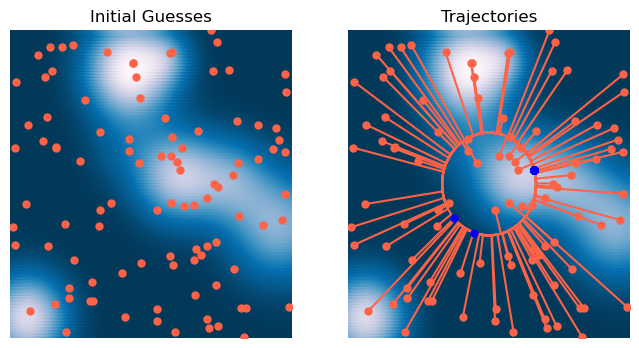

In [19]:
x = np.linspace(-3, 3, 100)
y = np.linspace(-3, 3, 100)
xx, yy = np.meshgrid(x, y)
X = np.array([xx.ravel(), yy.ravel()]).T
Z = loss.loss(X)

plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.scatter(X[:, 0], X[:, 1], c=Z)
plt.plot(*X0.T, '.')
plt.xlim([-3, 3])
plt.ylim([-3, 3])
plt.axis('off')
plt.title('Initial Guesses')

plt.subplot(1, 2, 2)
Xs = np.array(optimizer.Xs)
plt.scatter(X[:, 0], X[:, 1], c=Z)
plt.plot(Xs[0, :, 0], Xs[0, :, 1], '.');
plt.plot(Xs[:, :, 0], Xs[:, :, 1], '-');
plt.plot(Xs[-1, :, 0], Xs[-1, :, 1], '.b', zorder=10);
plt.xlim([-3, 3])
plt.ylim([-3, 3])
plt.axis('off')
plt.title('Trajectories')

Text(0, 0.5, 'Loss')

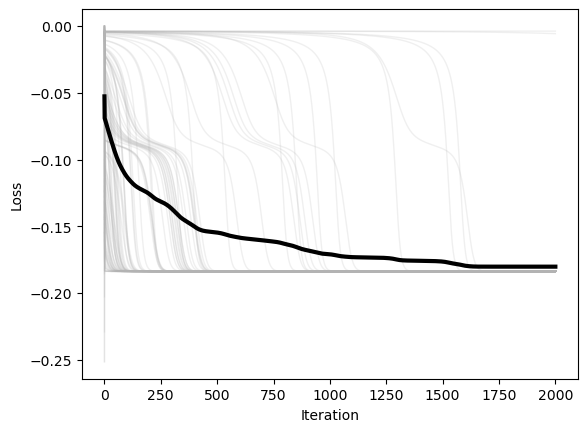

In [10]:
plt.figure()
plt.plot(optimizer.losses, color=(0.7, 0.7, 0.7), lw=1, alpha=0.2)
plt.plot(np.mean(optimizer.losses, axis=1), 'k', lw=3)
plt.xlabel('Iteration')
plt.ylabel('Loss')


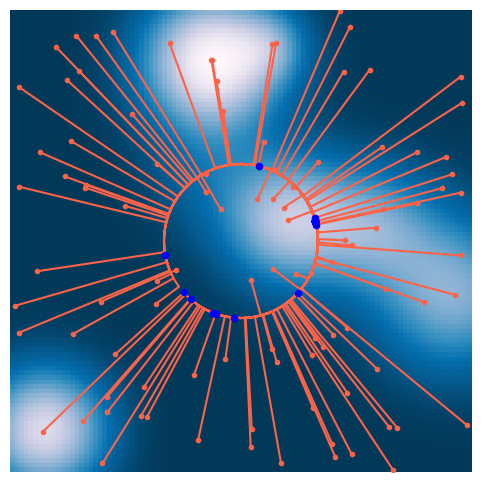

In [ ]:
from matplotlib.animation import FuncAnimation
from matplotlib.collections import LineCollection
from IPython.display import HTML

Xs = np.array(optimizer.Xs)[::2][:500]

fig, ax = plt.subplots(figsize=(6, 6))
# ax.scatter(X[:, 0], X[:, 1], c=Z, s=14, zorder=0)
plt.imshow(Z.reshape(100, 100), extent=[-3, 3, -3, 3], origin='lower')
ax.plot(Xs[0, :, 0], Xs[0, :, 1], '.', ms=6, linestyle='None', zorder=1)
curr = ax.scatter([], [], s=20, c='b', zorder=3)
trail = LineCollection([], zorder=2)
ax.add_collection(trail)

ax.set_xlim(-3, 3); ax.set_ylim(-3, 3); ax.axis('off')
plt.margins(0, 0); plt.gca().xaxis.set_major_locator(plt.NullLocator())
plt.gca().yaxis.set_major_locator(plt.NullLocator())

def init():
    curr.set_offsets(np.array([0, 0]))
    trail.set_segments([])
    return (curr, trail)

def update(t):
    # current points
    curr.set_offsets(Xs[t])

    if t > 0:
        segs = []
        # Build one polyline per particle (skip if fewer than 2 points)
        for n in range(Xs.shape[1]):
            path = Xs[:t+1, n, :]  # (k,2)
            if path.shape[0] >= 2:
                segs.append(path)
        trail.set_segments(segs)


    return (curr, trail)

ani = FuncAnimation(fig, update, frames=min(500, Xs.shape[0]),
                    init_func=init, interval=100, blit=True, repeat=True)
html = ani.to_html5_video()                                 # replaces to_jshtml()
HTML(html)

### What about inequality constraints? 

What if we don't require strictly that the individual elements $x_i$ add up to something, but instead that they are bounded? For example, $\sum_i x_i^2 \leq 1$ or $0 \leq x_i \leq 1$?

When we are constrained to subdomain, but *not* a subspace. This is the setting for Interior Point methods. See the [textbook by Boyd and Vandenberghe](https://web.stanford.edu/~boyd/cvxbook/) for discussion of these methods

<br><br><br><br><br><br>

# Equality constrained optimization with Lagrange multipliers

A more general way to enforce equality constraints is to add a Lagrange multiplier term to the loss function. For example, for our unit norm constraint, we augment the loss function to the following,
$$
    \mathcal{L}^{(a)}(\mathbf{x}, \lambda) = \mathcal{L}(\mathbf{x}) + \lambda \left( \mathbf{x}^T \mathbf{x} - 1 \right)
$$
where $\lambda$ is a Lagrange multiplier.

We can then solve the following optimization problem:
$$
    \mathbf{x}^* = \arg \min_{\mathbf{x}} \mathcal{L}^{(a)}(\mathbf{x}, \lambda)
$$


We can optimize the augmented loss function by first performing a gradient descent update on the augmented loss function,
$$
    \mathbf{x} \leftarrow \mathbf{x} - \eta \nabla \mathcal{L}^{(a)}(\mathbf{x}, \lambda)
$$
We then update the Lagrange multiplier:
$$
\lambda \leftarrow \lambda + \eta \nabla_\lambda \mathcal{L}^{(a)}(\mathbf{x}, \lambda)
$$
Note that we are doing gradient *ascent* on the Lagrange multiplier, since we don't necessarily want to minimize the function with respect to $\lambda$. This algorithm represents a version of [*Lagrangian duality*](https://people.cs.umass.edu/~domke/courses/sml/07lagrange.pdf).

<br></br>

For our norm-constrained example, we write the gradient of the augmented loss function in terms of the gradient of the loss function and the gradient of the constraint,
$$
    \nabla \mathcal{L}^{(a)}(\mathbf{x}, \lambda) = \mathcal{L}(\mathbf{x}) + \lambda \mathbf{x}
$$
and the gradient of the Lagrange multiplier is
$$
    \nabla_\lambda \mathcal{L}^{(a)}(\mathbf{x}, \lambda) = \mathbf{x}^T \mathbf{x} - 1
$$
We can see that, when the constraint is further from being satisfied, the influence of the constraint grows stronger. In our implementation, we will record the history of the Lagrange multiplier $\lambda$ in addition to the history of the optimizer state $\mathbf{x}$

In [35]:
class GradientDescentLagrange(BaseOptimizer):
    """A Multivariate Gradient Descent Optimize with Lagrange Multipliers"""

    def __init__(self, loss, lam, **kwargs):
        super().__init__(loss, **kwargs)
        self.lam = lam # Lagrange multiplier hyperparameter
        self.lam_history = [0.5]

    def update(self, X):
        grad = self.loss.grad(X)
        self.lam = self.lam + self.lr * (np.einsum('ij,ij->i', X, X) - 1)
        if self.store_history:
            self.lam_history.append(self.lam)
        return X - self.lr * (grad + self.lam[..., None] * X)

    

In [32]:
# Initialize optimizer
optimizer = GradientDescentLagrange(loss, lr=0.1, lam=0.5, max_iter=2000, tol=1e-6, random_state=0, store_history=True)

# Initialize starting point
X0 = 6 * np.random.random(size=(100, 2)) - 3

# Fit optimizer
optimizer.fit(X0.copy())

Text(0.5, 1.0, 'Trajectories')

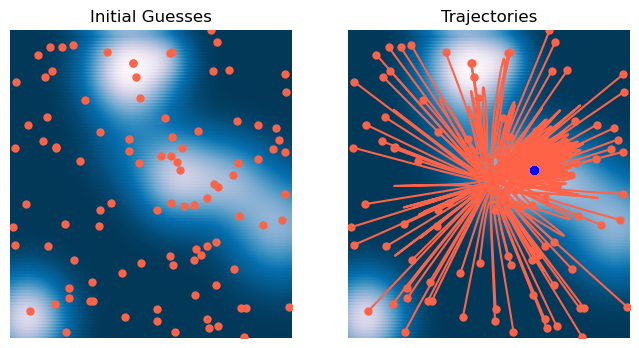

In [33]:
x = np.linspace(-3, 3, 100)
y = np.linspace(-3, 3, 100)
xx, yy = np.meshgrid(x, y)
X = np.array([xx.ravel(), yy.ravel()]).T
Z = loss.loss(X)

plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.scatter(X[:, 0], X[:, 1], c=Z)
plt.plot(*X0.T, '.')
plt.xlim([-3, 3])
plt.ylim([-3, 3])
plt.axis('off')
plt.title('Initial Guesses')

plt.subplot(1, 2, 2)
Xs = np.array(optimizer.Xs)
plt.scatter(X[:, 0], X[:, 1], c=Z)
plt.plot(Xs[0, :, 0], Xs[0, :, 1], '.');
plt.plot(Xs[:, :, 0], Xs[:, :, 1], '-');
plt.plot(Xs[-1, :, 0], Xs[-1, :, 1], '.b', zorder=10);
plt.xlim([-3, 3])
plt.ylim([-3, 3])
plt.axis('off')
plt.title('Trajectories')

Text(0, 0.5, 'Lagrange Multiplier')

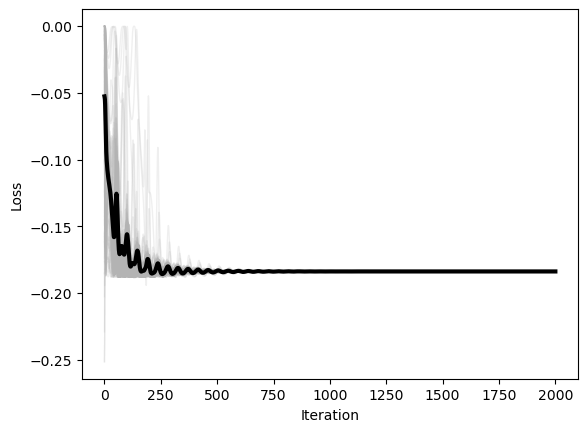

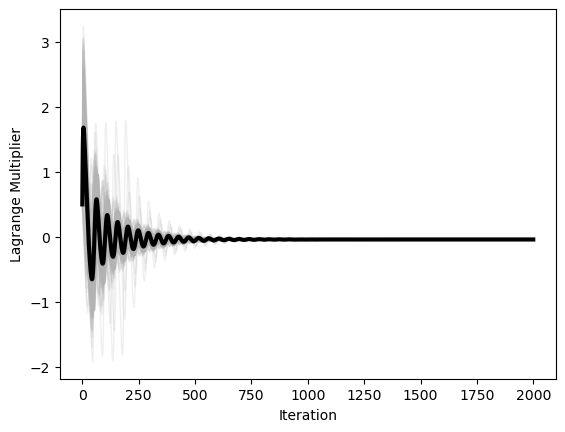

In [39]:
plt.figure()
plt.plot(optimizer.losses, color=(0.7, 0.7, 0.7), lw=1, alpha=0.2)
plt.plot(np.mean(optimizer.losses, axis=1), 'k', lw=3)
plt.xlabel('Iteration')
plt.ylabel('Loss')


## The first history element is a scalar, so we need to convert it to an array
optimizer.lam_history[0] = np.ones_like(optimizer.lam_history[1]) * optimizer.lam_history[0]
optimizer.lam_history = np.array(optimizer.lam_history)
plt.figure()
plt.plot(optimizer.lam_history, color=(0.7, 0.7, 0.7), lw=1, alpha=0.2)
plt.plot(np.mean(optimizer.lam_history, axis=1), 'k', lw=3)
plt.xlabel('Iteration')
plt.ylabel('Lagrange Multiplier')


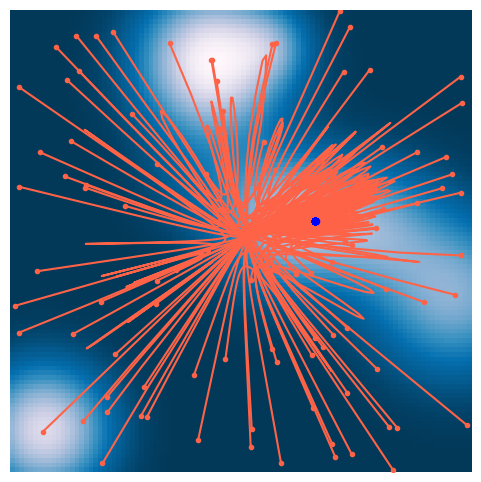

In [40]:
from matplotlib.animation import FuncAnimation
from matplotlib.collections import LineCollection
from IPython.display import HTML

Xs = np.array(optimizer.Xs)[::2][:500]

fig, ax = plt.subplots(figsize=(6, 6))
# ax.scatter(X[:, 0], X[:, 1], c=Z, s=14, zorder=0)
plt.imshow(Z.reshape(100, 100), extent=[-3, 3, -3, 3], origin='lower')
ax.plot(Xs[0, :, 0], Xs[0, :, 1], '.', ms=6, linestyle='None', zorder=1)
curr = ax.scatter([], [], s=20, c='b', zorder=3)
trail = LineCollection([], zorder=2)
ax.add_collection(trail)

ax.set_xlim(-3, 3); ax.set_ylim(-3, 3); ax.axis('off')
plt.margins(0, 0); plt.gca().xaxis.set_major_locator(plt.NullLocator())
plt.gca().yaxis.set_major_locator(plt.NullLocator())

def init():
    curr.set_offsets(np.array([0, 0]))
    trail.set_segments([])
    return (curr, trail)

def update(t):
    # current points
    curr.set_offsets(Xs[t])

    if t > 0:
        segs = []
        # Build one polyline per particle (skip if fewer than 2 points)
        for n in range(Xs.shape[1]):
            path = Xs[:t+1, n, :]  # (k,2)
            if path.shape[0] >= 2:
                segs.append(path)
        trail.set_segments(segs)


    return (curr, trail)

ani = FuncAnimation(fig, update, frames=min(500, Xs.shape[0]),
                    init_func=init, interval=100, blit=True, repeat=True)
html = ani.to_html5_video()                                 # replaces to_jshtml()
HTML(html)